In [96]:
import pandas as pd
import os, sys 
sys.path.append(os.getcwd()[:-9])  # add repo root to path
from utils import get_repo_root

import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier, early_stopping, log_evaluation
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from imblearn.under_sampling import TomekLinks


In [97]:
repo_root = get_repo_root()

In [98]:
input_set = pd.read_csv(str(repo_root) + '/data/features_all.csv')
ref_test = pd.read_csv(str(repo_root) + '/data/referance_data_test.csv')
ref = pd.read_csv(str(repo_root) + '/data/referance_data.csv')

In [99]:
input_set.head()

,cust_id,ref_date,mobile_eft_all_cnt_l0m,mobile_eft_all_cnt_l2m,mobile_eft_all_cnt_l5m,mobile_eft_all_cnt_l8m,mobile_eft_all_cnt_l1year,mobile_eft_all_cnt_l2years,mobile_eft_all_cnt_l4years,active_product_category_nbr_l0m,...,cc_transaction_all_cnt_to_active_product_category_nbr_ratio,mobile_eft_all_cnt_to_active_product_category_nbr_ratio,months_since_first,months_until_last,lifetime_months,month,quarter,moy_sin,moy_cos,is_q_end
0,0,2017-09-01,1.0,4.0,7.0,5.0,13.0,17.0,0.0,2.0,...,0.000000,0.500000,20,0,21,9,3,-1.000000,-1.836970e-16,1
1,1,2019-02-01,0.0,1.0,8.0,3.0,4.0,23.0,22.0,3.0,...,2.666667,0.000000,37,0,38,2,1,0.866025,5.000000e-01,0
2,2,2019-01-01,1.0,5.0,7.0,3.0,5.0,32.0,34.0,3.0,...,2.333333,0.333333,36,0,37,1,1,0.500000,8.660254e-01,0
3,3,2018-10-01,2.0,2.0,3.0,6.0,9.0,16.0,19.0,3.0,...,7.000000,0.666667,33,0,34,10,4,-0.866025,5.000000e-01,0
4,5,2018-03-01,4.0,9.0,10.0,10.0,14.0,17.0,5.0,2.0,...,1.500000,2.000000,26,0,27,3,1,1.000000,6.123234e-17,1


In [100]:
input_set_with_labels = input_set.merge(ref, on=['cust_id', 'ref_date'], how='left')
training_data = input_set_with_labels[input_set_with_labels['churn'].notna()]
test_data = input_set_with_labels[input_set_with_labels['churn'].isna()]

In [101]:
test_data

,cust_id,ref_date,mobile_eft_all_cnt_l0m,mobile_eft_all_cnt_l2m,mobile_eft_all_cnt_l5m,mobile_eft_all_cnt_l8m,mobile_eft_all_cnt_l1year,mobile_eft_all_cnt_l2years,mobile_eft_all_cnt_l4years,active_product_category_nbr_l0m,...,mobile_eft_all_cnt_to_active_product_category_nbr_ratio,months_since_first,months_until_last,lifetime_months,month,quarter,moy_sin,moy_cos,is_q_end,churn
1,1,2019-02-01,0.0,1.0,8.0,3.0,4.0,23.0,22.0,3.0,...,0.000000,37,0,38,2,1,8.660254e-01,5.000000e-01,0,NaN
2,2,2019-01-01,1.0,5.0,7.0,3.0,5.0,32.0,34.0,3.0,...,0.333333,36,0,37,1,1,5.000000e-01,8.660254e-01,0,NaN
8,9,2019-03-01,1.0,3.0,6.0,5.0,6.0,33.0,76.0,2.0,...,0.500000,38,0,39,3,1,1.000000e+00,6.123234e-17,1,NaN
14,15,2019-06-01,0.0,1.0,3.0,6.0,11.0,32.0,30.0,3.0,...,0.000000,41,0,42,6,2,1.224647e-16,-1.000000e+00,1,NaN
18,19,2019-01-01,1.0,2.0,5.0,6.0,7.0,29.0,25.0,3.0,...,0.333333,36,0,37,1,1,5.000000e-01,8.660254e-01,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176248,199951,2019-03-01,4.0,5.0,10.0,4.0,12.0,26.0,26.0,3.0,...,1.333333,38,0,39,3,1,1.000000e+00,6.123234e-17,1,NaN
176249,199952,2019-05-01,1.0,2.0,3.0,0.0,0.0,17.0,10.0,3.0,...,0.333333,40,0,41,5,2,5.000000e-01,-8.660254e-01,0,NaN
176260,199963,2019-05-01,5.0,11.0,19.0,19.0,5.0,66.0,148.0,2.0,...,2.500000,40,0,41,5,2,5.000000e-01,-8.660254e-01,0,NaN
176261,199964,2019-03-01,5.0,6.0,12.0,7.0,5.0,16.0,19.0,3.0,...,1.666667,38,0,39,3,1,1.000000e+00,6.123234e-17,1,NaN


In [67]:
training_data.dtypes[training_data.dtypes=='object']

ref_date    object
date        object
dtype: object

/Users/yasin.secal/Desktop/yasins/ing_hubs/ing-datathon-team-guney-kampus/venv/lib/python3.12/site-packages/scipy/stats/_stats_py.py:5405: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rpb, prob = pearsonr(x, y)


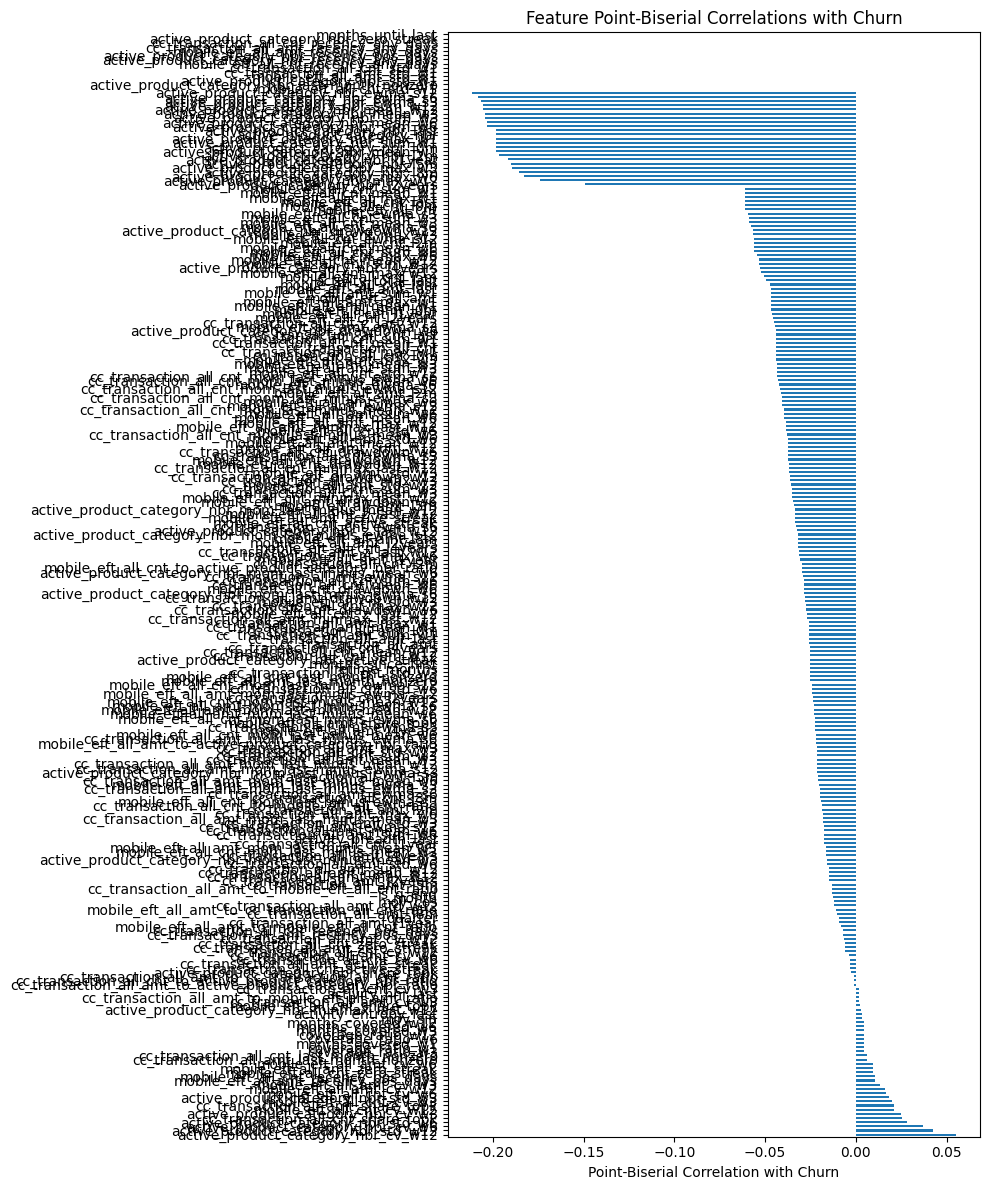

In [102]:
from scipy.stats import pointbiserialr

# Calculate point-biserial correlations with churn column
pb_correlations = {}
feature_cols = training_data.drop(['cust_id', 'ref_date','date', 'churn'], axis=1).columns

for col in feature_cols:
    corr, _ = pointbiserialr(training_data['churn'], training_data[col])
    pb_correlations[col] = corr

# Convert to Series and sort
pb_corr_series = pd.Series(pb_correlations).sort_values(ascending=False)

# Plot the correlations
plt.figure(figsize=(10, 12))
pb_corr_series.plot(kind='barh')
plt.xlabel('Point-Biserial Correlation with Churn')
plt.title('Feature Point-Biserial Correlations with Churn')
plt.tight_layout()
plt.show()

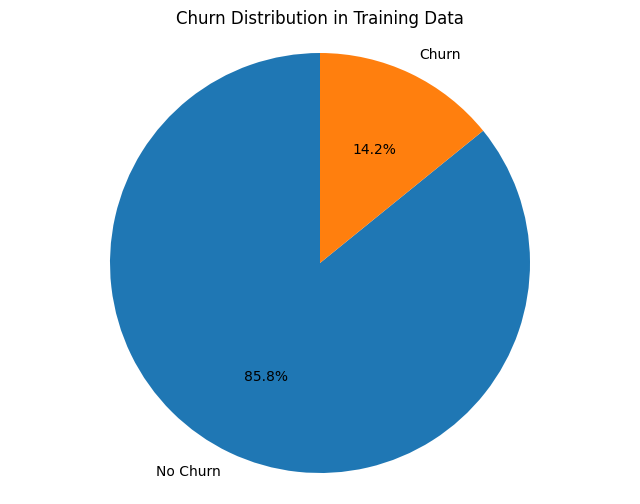

In [103]:
import matplotlib.pyplot as plt

# Count the values in churn column
churn_counts = training_data['churn'].value_counts()

# Create pie chart
plt.figure(figsize=(8, 6))
plt.pie(churn_counts, labels=['No Churn', 'Churn'], autopct='%1.1f%%', startangle=90)
plt.title('Churn Distribution in Training Data')
plt.axis('equal')
plt.show()

## MODELLING

In [104]:
from utils.ml_functions import ing_hubs_datathon_metric 
from utils.ml_functions import OptunaTuner

In [105]:
training_data['date']

0         2017-09-01
3         2018-10-01
4         2018-03-01
5         2018-04-01
6         2018-05-01
             ...    
176288    2018-09-01
176289    2018-06-01
176290    2018-12-01
176291    2018-02-01
176292    2018-06-01
Name: date, Length: 133287, dtype: object

In [72]:
training_data.iloc[:, 2:-1]

,mobile_eft_all_cnt_l0m,mobile_eft_all_cnt_l2m,mobile_eft_all_cnt_l5m,mobile_eft_all_cnt_l8m,mobile_eft_all_cnt_l1year,mobile_eft_all_cnt_l2years,mobile_eft_all_cnt_l4years,mobile_eft_all_amt_l0m,mobile_eft_all_amt_l2m,mobile_eft_all_amt_l5m,...,cc_transaction_all_amt_minmax_last_w12,total_amt_share_topk,months_since_first,months_until_last,lifetime_months,month,quarter,moy_sin,moy_cos,is_q_end
0,1.0,4.0,7.0,5.0,13.0,17.0,0.0,212.75,478.34,352.52,...,NaN,NaN,20,0,21,9,3,-1.000000e+00,-1.836970e-16,1
3,2.0,2.0,3.0,6.0,9.0,16.0,19.0,498.99,567.47,484.37,...,0.905346,1.0,33,0,34,10,4,-8.660254e-01,5.000000e-01,0
4,4.0,9.0,10.0,10.0,14.0,17.0,5.0,723.01,2451.56,1722.46,...,0.321788,1.0,26,0,27,3,1,1.000000e+00,6.123234e-17,1
5,6.0,12.0,13.0,13.0,17.0,102.0,37.0,262.55,727.64,970.63,...,0.002601,1.0,27,0,28,4,2,8.660254e-01,-5.000000e-01,0
6,0.0,0.0,0.0,0.0,0.0,18.0,5.0,0.00,0.00,0.00,...,0.107472,1.0,28,0,29,5,2,5.000000e-01,-8.660254e-01,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176288,5.0,11.0,10.0,3.0,4.0,3.0,10.0,636.55,1780.19,834.82,...,0.000000,1.0,32,0,33,9,3,-1.000000e+00,-1.836970e-16,1
176289,1.0,7.0,9.0,5.0,7.0,25.0,6.0,76.94,183.39,226.04,...,0.944516,1.0,29,0,30,6,2,1.224647e-16,-1.000000e+00,1
176290,4.0,8.0,15.0,21.0,46.0,187.0,45.0,1407.68,3188.80,7245.40,...,0.080464,1.0,35,0,36,12,4,-2.449294e-16,1.000000e+00,1
176291,6.0,14.0,11.0,15.0,17.0,28.0,2.0,566.82,1996.30,2626.80,...,0.244788,1.0,25,0,26,2,1,8.660254e-01,5.000000e-01,0


In [106]:
X = training_data.drop(['cust_id', 'ref_date','date', 'churn'], axis=1)
y = training_data['churn']

In [107]:
studies = {
     "None_XGBClassifier_LogLoss_INGHubsMetric": OptunaTuner(
        model_name="XGBoost",
        sampler=None,
        loss="binary:logistic",
        eval_metric="ing_hubs_datathon_metric",    # Used for CV scoring only
        n_trials=5,
        study_name="None_XGBClassifier_LogLoss_INGHubsMetric"
    ),
    "RandomOverSampler_XGBClassifier_LogLoss_INGHubsMetric": OptunaTuner(
        model_name="XGBoost",
        sampler="RandomOverSampler",
        loss="binary:logistic",
        eval_metric="ing_hubs_datathon_metric",    # Used for CV scoring only
        n_trials=5,
        study_name="RandomOverSampler_XGBClassifier_LogLoss_INGHubsMetric"
    ),
    "SMOTE_XGBClassifier_LogLoss_INGHubsMetric": OptunaTuner(
        model_name="XGBoost",
        sampler="SMOTE",
        loss="binary:logistic",
        eval_metric="ing_hubs_datathon_metric",    # Used for CV scoring only
        n_trials=5,
        study_name="SMOTE_XGBClassifier_LogLoss_INGHubsMetric"
    ),
    "SMOTE_RandomForestClassifier_LogLoss_INGHubsMetric": OptunaTuner(
        model_name="RandomForest",
        sampler="SMOTE",        
        eval_metric="ing_hubs_datathon_metric",    # Used for CV scoring only
        n_trials=5,
        study_name="SMOTE_RandomForestClassifier_LogLoss_INGHubsMetric"
    )
}

In [108]:
study1 = studies["None_XGBClassifier_LogLoss_INGHubsMetric"].optimize(X, y)

  0%|          | 0/5 [00:00<?, ?it/s]


Study Name: None_XGBClassifier_LogLoss_INGHubsMetric
  Train size: 106629, Val size: 26658
  Train class dist: [91533 15096]
  Val class dist: [22884  3774]
  Pred proba range: [0.0000, 0.9855]
  Pred labels dist: [23066  3592]
[I 2025-10-20 23:44:03] Trial 0 finished with value: 0.91 and parameters: {'n_estimators': 574, 'learning_rate': '0.23', 'max_depth': 8, 'min_child_weight': '0.63', 'subsample': '0.58', 'colsample_bytree': '0.58', 'gamma': '0.58', 'reg_alpha': '0.62', 'reg_lambda': '0.00', 'max_bin': 400}. Best is trial 0 with value: 0.91.
[I 2025-10-20 23:44:31] Trial 1 finished with value: 0.90 and parameters: {'n_estimators': 220, 'learning_rate': '0.25', 'max_depth': 9, 'min_child_weight': '0.04', 'subsample': '0.59', 'colsample_bytree': '0.59', 'gamma': '3.04', 'reg_alpha': '0.00', 'reg_lambda': '0.00', 'max_bin': 240}. Best is trial 0 with value: 0.91.
[I 2025-10-20 23:45:26] Trial 2 finished with value: 1.16 and parameters: {'n_estimators': 812, 'learning_rate': '0.00', 

In [42]:
study1.best_params

{'n_estimators': 574,
 'learning_rate': 0.22648248189516842,
 'max_depth': 8,
 'min_child_weight': 0.6251373574521749,
 'subsample': 0.5780093202212182,
 'colsample_bytree': 0.5779972601681014,
 'gamma': 0.5808361216819946,
 'reg_alpha': 0.6245760287469887,
 'reg_lambda': 0.002570603566117596,
 'max_bin': 400}

In [43]:
model = XGBClassifier(**study1.best_params)

In [44]:
model.fit(X, y)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.5779972601681014
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [109]:
study2 = studies["RandomOverSampler_XGBClassifier_LogLoss_INGHubsMetric"].optimize(X, y)

  0%|          | 0/5 [00:00<?, ?it/s]


Study Name: RandomOverSampler_XGBClassifier_LogLoss_INGHubsMetric
  Train size: 183066, Val size: 26658
  Train class dist: [91533 91533]
  Val class dist: [22884  3774]
  Pred proba range: [0.0000, 0.9813]
  Pred labels dist: [24133  2525]
[I 2025-10-20 23:47:59] Trial 0 finished with value: 0.95 and parameters: {'n_estimators': 574, 'learning_rate': '0.23', 'max_depth': 8, 'min_child_weight': '0.63', 'subsample': '0.58', 'colsample_bytree': '0.58', 'gamma': '0.58', 'reg_alpha': '0.62', 'reg_lambda': '0.00', 'max_bin': 400}. Best is trial 0 with value: 0.95.
[I 2025-10-20 23:48:29] Trial 1 finished with value: 0.93 and parameters: {'n_estimators': 220, 'learning_rate': '0.25', 'max_depth': 9, 'min_child_weight': '0.04', 'subsample': '0.59', 'colsample_bytree': '0.59', 'gamma': '3.04', 'reg_alpha': '0.00', 'reg_lambda': '0.00', 'max_bin': 240}. Best is trial 0 with value: 0.95.
[I 2025-10-20 23:49:47] Trial 2 finished with value: 1.17 and parameters: {'n_estimators': 812, 'learning_ra

In [78]:
study3 = studies["SMOTE_XGBClassifier_LogLoss_INGHubsMetric"].optimize(X, y)

  0%|          | 0/5 [00:00<?, ?it/s]

/Users/yasin.secal/Desktop/yasins/ing_hubs/ing-datathon-team-guney-kampus/utils/ml_functions.py:411: UserWarning: Sampler SMOTE failed on this fold (Input X contains NaN.
SMOTE does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values). Skipping sampling.
  warnings.warn(



Study Name: SMOTE_XGBClassifier_LogLoss_INGHubsMetric
  Train size: 106629, Val size: 26658
  Train class dist: [91533 15096]
  Val class dist: [22884  3774]
  Pred proba range: [0.0126, 0.7503]
  Pred labels dist: [26581    77]


/Users/yasin.secal/Desktop/yasins/ing_hubs/ing-datathon-team-guney-kampus/utils/ml_functions.py:411: UserWarning: Sampler SMOTE failed on this fold (Input X contains NaN.
SMOTE does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values). Skipping sampling.
  warnings.warn(
/Users/yasin.secal/Desktop/yasins/ing_hubs/ing-datathon-team-guney-kampus/utils/ml_functions.py:411: UserWarning: Sampler SMOTE failed on this fold (Input X contains NaN.
SMOTE does not

[I 2025-10-20 20:23:46] Trial 0 finished with value: 1.01 and parameters: {'n_estimators': 574, 'learning_rate': '0.23', 'max_depth': 8, 'min_child_weight': '0.63', 'subsample': '0.58', 'colsample_bytree': '0.58', 'gamma': '0.58', 'reg_alpha': '0.62', 'reg_lambda': '0.00', 'max_bin': 400}. Best is trial 0 with value: 1.01.


/Users/yasin.secal/Desktop/yasins/ing_hubs/ing-datathon-team-guney-kampus/utils/ml_functions.py:411: UserWarning: Sampler SMOTE failed on this fold (Input X contains NaN.
SMOTE does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values). Skipping sampling.
  warnings.warn(
/Users/yasin.secal/Desktop/yasins/ing_hubs/ing-datathon-team-guney-kampus/utils/ml_functions.py:411: UserWarning: Sampler SMOTE failed on this fold (Input X contains NaN.
SMOTE does not

[I 2025-10-20 20:23:50] Trial 1 finished with value: 0.97 and parameters: {'n_estimators': 220, 'learning_rate': '0.25', 'max_depth': 9, 'min_child_weight': '0.04', 'subsample': '0.59', 'colsample_bytree': '0.59', 'gamma': '3.04', 'reg_alpha': '0.00', 'reg_lambda': '0.00', 'max_bin': 240}. Best is trial 0 with value: 1.01.


/Users/yasin.secal/Desktop/yasins/ing_hubs/ing-datathon-team-guney-kampus/utils/ml_functions.py:411: UserWarning: Sampler SMOTE failed on this fold (Input X contains NaN.
SMOTE does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values). Skipping sampling.
  warnings.warn(
/Users/yasin.secal/Desktop/yasins/ing_hubs/ing-datathon-team-guney-kampus/utils/ml_functions.py:411: UserWarning: Sampler SMOTE failed on this fold (Input X contains NaN.
SMOTE does not

[I 2025-10-20 20:24:16] Trial 2 finished with value: 1.08 and parameters: {'n_estimators': 812, 'learning_rate': '0.00', 'max_depth': 5, 'min_child_weight': '0.13', 'subsample': '0.73', 'colsample_bytree': '0.89', 'gamma': '2.00', 'reg_alpha': '0.00', 'reg_lambda': '0.00', 'max_bin': 145}. Best is trial 2 with value: 1.08.


/Users/yasin.secal/Desktop/yasins/ing_hubs/ing-datathon-team-guney-kampus/utils/ml_functions.py:411: UserWarning: Sampler SMOTE failed on this fold (Input X contains NaN.
SMOTE does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values). Skipping sampling.
  warnings.warn(
/Users/yasin.secal/Desktop/yasins/ing_hubs/ing-datathon-team-guney-kampus/utils/ml_functions.py:411: UserWarning: Sampler SMOTE failed on this fold (Input X contains NaN.
SMOTE does not

[I 2025-10-20 20:24:37] Trial 3 finished with value: 1.06 and parameters: {'n_estimators': 808, 'learning_rate': '0.00', 'max_depth': 3, 'min_child_weight': '7.03', 'subsample': '0.98', 'colsample_bytree': '0.90', 'gamma': '3.05', 'reg_alpha': '0.00', 'reg_lambda': '0.01', 'max_bin': 297}. Best is trial 2 with value: 1.08.


/Users/yasin.secal/Desktop/yasins/ing_hubs/ing-datathon-team-guney-kampus/utils/ml_functions.py:411: UserWarning: Sampler SMOTE failed on this fold (Input X contains NaN.
SMOTE does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values). Skipping sampling.
  warnings.warn(
/Users/yasin.secal/Desktop/yasins/ing_hubs/ing-datathon-team-guney-kampus/utils/ml_functions.py:411: UserWarning: Sampler SMOTE failed on this fold (Input X contains NaN.
SMOTE does not

[I 2025-10-20 20:24:46] Trial 4 finished with value: 1.08 and parameters: {'n_estimators': 322, 'learning_rate': '0.02', 'max_depth': 3, 'min_child_weight': '5.35', 'subsample': '0.63', 'colsample_bytree': '0.83', 'gamma': '3.12', 'reg_alpha': '0.00', 'reg_lambda': '0.00', 'max_bin': 199}. Best is trial 2 with value: 1.08.


In [ ]:

model = XGBClassifier(**study3.best_params)
model.fit(X, y)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8925879806965068
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [84]:
X.fillna(0, inplace=True)

In [87]:
X_test = test_data.drop(['cust_id', 'ref_date','date', 'churn'], axis=1)

In [90]:
# Get best parameters from study3
best_params = study3.best_params

# Get the tuner object for study3
tuner = studies["SMOTE_XGBClassifier_LogLoss_INGHubsMetric"]

# Apply SMOTE resampling
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Create and train XGBoost model with best parameters
model = XGBClassifier(**best_params, random_state=42)
model.fit(X_resampled, y_resampled)

# Prepare test data features
# Make predictions on test data
test_predictions = model.predict_proba(X_test)[:, 1]

# Create submission dataframe
submission = ref_test.copy()
submission['churn'] = test_predictions

print(f"Best parameters: {best_params}")
print(f"Predictions shape: {test_predictions.shape}")
print(submission.head())

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [93]:
submission

,cust_id,churn
0,1,0.289059
1,2,0.244858
2,9,0.461760
3,15,0.208675
4,19,0.230808
...,...,...
43001,199951,0.194774
43002,199952,0.226826
43003,199963,0.397119
43004,199964,0.144990


In [95]:
submission.to_csv(str(repo_root) + '/submission_xgboost_smote.csv', index=False)

In [ ]:
model.predict(test_data[])

TO DO 

* optimize fonksiyonunu study fonksiyonu olarak güncelle ve parametreleri + inputları + modeli bir JSON'a yazdır, bu JSON'ı return et.
* JSON dosyalarını kullanarak tekrar train et ve modeli .pkl olarak kaydet.
* feature kısmına daha doğru düzgün odaklan. 